# Strong Scaling Analysis

## 1. Introduction

This notebook presents a **strong scaling analysis** of our MPI-parallel wave equation solver, implemented with the [deal.II](https://www.dealii.org/) finite element library and Trilinos linear algebra backend.

We solve the 2D wave equation on the unit square $\Omega = [0,1]^2$ with homogeneous Dirichlet boundary conditions and an exact standing-mode solution:

$$u(x,y,t) = \cos(\sqrt{2}\,\pi\,t)\,\sin(\pi x)\,\sin(\pi y)$$

with wave speed $c=1$, zero forcing $f=0$, and initial conditions $u_0 = \sin(\pi x)\sin(\pi y)$, $v_0 = 0$.

### Time integration schemes tested

| Scheme | Parameters | Type |
|:-------|:-----------|:-----|
| **$\theta$-method, $\theta=0$** | Forward Euler (explicit) | Conditionally stable |
| **$\theta$-method, $\theta=0.5$** | Crank–Nicolson (implicit) | Unconditionally stable |
| **$\theta$-method, $\theta=1$** | Backward Euler (implicit) | Unconditionally stable |
| **Newmark, $\beta=0$, $\gamma=0.5$** | Central differences (explicit) | Conditionally stable |
| **Newmark, $\beta=0.25$, $\gamma=0.5$** | Average acceleration (implicit) | Unconditionally stable |

### Problem parameters

| Parameter | Value | Rationale |
|:----------|:------|:----------|
| **Nel** | 640 | ~205,000 DOFs (P1 simplex)
| **R** | 1 | Polynomial degree (P1) |
| **Δt** | 0.0008 | $\Delta t < h/(c\sqrt{2}) \approx 0.0011$ for Nel=640 |
| **T** | 0.5 | 625 time steps |

### Linear solver

- **CG** (Conjugate Gradient) with `ReductionControl(10000, 1e-12, 1e-6)`
- **AMG preconditioner** (`TrilinosWrappers::PreconditionAMG`), built **once** on the BC-modified system matrix at the first time step, then reused for all subsequent steps (the system matrix is constant in time)

## 2. Experimental setup

### Hardware

We executed the tests on the "Students Cluster" from the Mathematics department, here the main informations (obtained from `lscpu`):
- **Intel Xeon Gold 6238R** × 2 sockets per node
- 28 physical cores / socket, 56 cores / node, 2 NUMA nodes
- 38.5 MB L3 cache per socket

### MPI configuration

- **OpenMPI** with `--bind-to core --map-by socket`
- Rank placement: rank 0 → socket 0, rank 1 → socket 1, ...
- `OMP_NUM_THREADS=1` to prevent hyper-threading

### Methodology

1. Each PBS job requests 16 CPUs on a **single node** (max allowed); all process counts (1, 2, 4, 8, 16) run sequentially
2. An additional **32-core** run is attempted opportunistically with `--oversubscribe`
3. **3 repeats** per configuration
4. Two jobs were submitted on **two different nodes** simultaneously, and results merged — giving 6 measurements per (scheme, nprocs) pair
5. Output I/O and logging are **disabled** (`Save Solution=false`, `Log Every=0`) 
6. We pick the **minimum wall time** (best run) across all the 6 of them, for performing the analisys

### Report of what we did

```bash
# login to the cluster
sudo gpclient connect gp-dmat-saml.vpn.polimi.it
ssh u11177200@10.78.18.100

# clone the repo
git clone https://github.com/AlessandroGhiotto/nmpde-wave-equation.git

# compile the c++ code
qsub -I -q cpu -l select=1:ncpus=16 -l walltime=24:00:00
cd nmpde-wave-equation
mkdir build
cd build
cmake ..
make -j
exit # from the Interactive session

# submit the job
cd nmpde-wave-equation/scripts
qsub -l select=1:ncpus=16:mpiprocs=16:host=cpu04 scaling_all.pbs
qsub -l select=1:ncpus=16:mpiprocs=16:host=cpu05 scaling_all.pbs
# (go to sleep)

# get the csv from the cluster: run the following on your local machine
scp u11177200@10.78.18.100:/home/u11177200/nmpde-wave-equation/scripts/scalability-results-all-cpu03.mate.polimi.it_9422.csv ./
scp u11177200@10.78.18.100:/home/u11177200/nmpde-wave-equation/scripts/scalability-results-all-cpu04.mate.polimi.it_9420.csv ./
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

In [2]:
# ------------------------------------------------------------------
# Load & clean data (merged CSV from two cluster nodes, 3 repeats each)
# ------------------------------------------------------------------
csv_path = Path('scalability-results-all.csv')
df = pd.read_csv(csv_path)

numeric_cols = ['nprocs', 'Nel', 'R', 'Dt', 'T', 'seconds', 'returncode']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Keep only successful runs
df = df[(df['returncode'] == 0) & df['seconds'].notna() & (df['seconds'] > 0)].copy()

# Best (minimum) time per (scheme, nprocs) across all repeats and both nodes
dedup_keys = ['scheme', 'nprocs', 'Nel', 'R', 'Dt', 'T', 'Theta', 'Beta', 'Gamma']
df = df.sort_values('seconds').drop_duplicates(subset=dedup_keys, keep='first')

print(f"Loaded {len(df)} unique (scheme, nprocs) measurements")
print(f"Schemes: {sorted(df['scheme'].unique())}")
print(f"nprocs:  {sorted(df['nprocs'].unique())}")
df[['scheme','nprocs','seconds']].sort_values(['scheme','nprocs'])

Loaded 30 unique (scheme, nprocs) measurements
Schemes: ['newmark-0.00', 'newmark-0.25', 'theta-0.0', 'theta-0.5', 'theta-1.0']
nprocs:  [np.int64(1), np.int64(2), np.int64(4), np.int64(8), np.int64(16), np.int64(32)]


,scheme,nprocs,seconds
99,newmark-0.00,1,116.517860
115,newmark-0.00,2,61.892394
130,newmark-0.00,4,33.754097
146,newmark-0.00,8,20.263796
160,newmark-0.00,16,12.317912
84,newmark-0.00,32,9.993134
102,newmark-0.25,1,338.870342
117,newmark-0.25,2,178.430777
134,newmark-0.25,4,95.459363
148,newmark-0.25,8,53.974801


In [3]:
# ------------------------------------------------------------------
# Compute strong-scaling metrics
# ------------------------------------------------------------------
group_keys = ['scheme', 'Nel', 'R', 'Dt', 'T', 'Theta', 'Beta', 'Gamma']

# Baseline: minimum p=1 time per scheme
base = (
    df[df['nprocs'] == 1][group_keys + ['seconds']]
    .rename(columns={'seconds': 't_base'})
    .groupby(group_keys, dropna=False, as_index=False)['t_base'].min()
)

dfm = df.merge(base, on=group_keys, how='left')
dfm = dfm[dfm['t_base'].notna()].copy()
dfm['speedup']    = dfm['t_base'] / dfm['seconds']
dfm['efficiency'] = dfm['speedup'] / dfm['nprocs']

# Aggregate: best performance per (scheme, nprocs)
dfm_agg = dfm.groupby(['scheme', 'nprocs'], as_index=False).agg({
    'seconds':    'min',
    'speedup':    'max',
    'efficiency': 'max',
    't_base':     'first',
})

# Pretty-print summary table
summary = dfm_agg.pivot_table(index='nprocs', columns='scheme', values=['seconds', 'speedup', 'efficiency'])
summary = summary.round(2)
display(summary)

efficiency                                                 seconds  \
scheme newmark-0.00 newmark-0.25 theta-0.0 theta-0.5 theta-1.0 newmark-0.00   
nprocs                                                                        
1              1.00         1.00      1.00      1.00      1.00       116.52   
2              0.94         0.95      0.94      0.90      0.90        61.89   
4              0.86         0.89      0.88      0.86      0.86        33.75   
8              0.72         0.78      0.79      0.78      0.78        20.26   
16             0.59         0.69      0.70      0.71      0.71        12.32   
32             0.36         0.48      0.50      0.53      0.52         9.99   

                                                       speedup               \
scheme newmark-0.25 theta-0.0 theta-0.5 theta-1.0 newmark-0.00 newmark-0.25   
nprocs                                                                        
1            338.87    360.33    641.54    658.35         1.00         1.00   
2            178.43    192.29    355.16    364.35         1.88         1.90   
4             95.46    101.93    186.74    192.11         3.45         3.55   
8             53.97     57.22    102.76    105.48         5.75         6.28   
16            30.84     32.14     56.57     58.29         9.46        10.99   
32            22.22     22.46     37.95     39.30        11.66        15.25   

                                      
scheme theta-0.0 theta-0.5 theta-1.0  
nprocs                                
1           1.00      1.00      1.00  
2           1.87      1.81      1.81  
4           3.54      3.44      3.43  
8           6.30      6.24      6.24  
16         11.21     11.34     11.29  
32         16.04     16.90     16.75

## 3. Results

### 3.1 Wall time comparison

The plot below shows absolute wall time (log scale) vs. number of MPI processes for all five schemes. Key observations:
- **Explicit methods** ($\theta=0$, Newmark $\beta=0$) are significantly faster in absolute terms since they only require mass-matrix solves (no stiffness contribution in the system matrix)
- **Newmark β=0** is the fastest overall — it solves a single system per step, while θ=0 solves two (one for $u$, one for $v$)
- **Implicit methods** ($\theta=0.5$, $\theta=1$, Newmark $\beta=0.25$) are slower due to the stiffness-coupled system, but all scale similarly

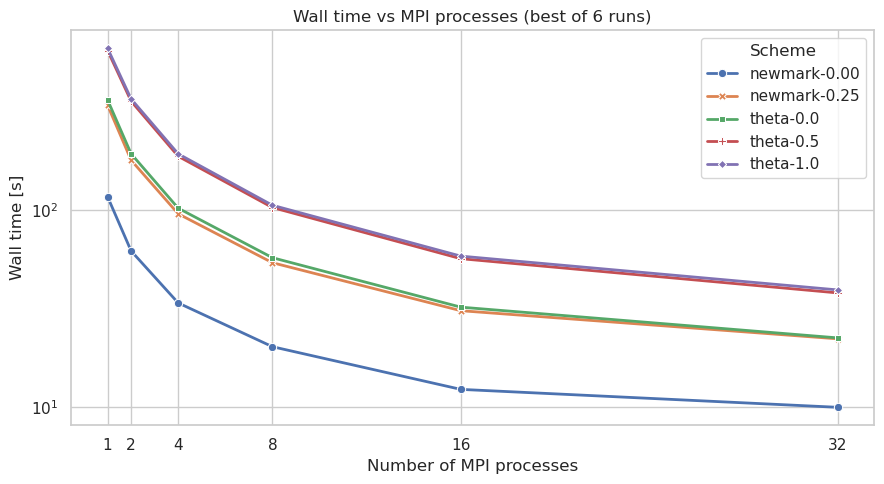

In [4]:
# --- Wall time (log scale) ---
plt.figure(figsize=(9, 5))
ax = sns.lineplot(
    data=dfm_agg, x='nprocs', y='seconds',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    errorbar=None,
)
ax.set_title('Wall time vs MPI processes (best of 6 runs)')
ax.set_xlabel('Number of MPI processes')
ax.set_ylabel('Wall time [s]')
ax.set_yscale('log')
ax.set_xticks(sorted(dfm_agg['nprocs'].unique()))
ax.legend(title='Scheme')
plt.tight_layout()

### 3.2 Speedup and efficiency

**Speedup** is defined as $S(p) = T(1)/T(p)$ and **efficiency** as $E(p) = S(p)/p$, where $T(p)$ is the best wall time across all repeats and nodes for $p$ processes.

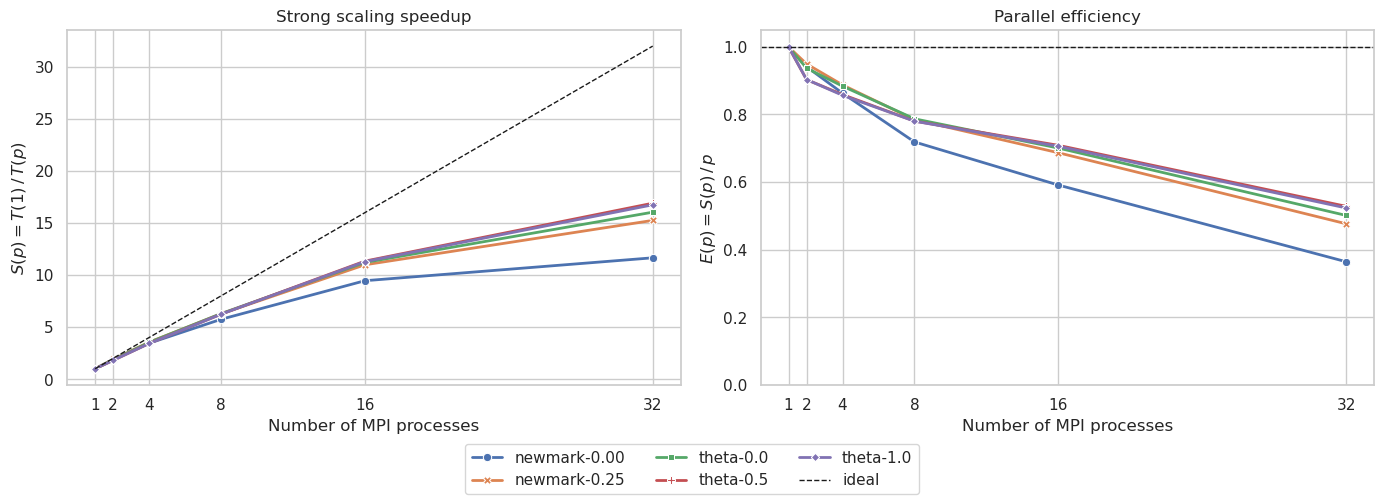

In [9]:
# --- Speedup & Efficiency (side by side) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.lineplot(
    data=dfm_agg, x='nprocs', y='speedup',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[0], errorbar=None,
)
p_max = dfm_agg['nprocs'].max()
axes[0].plot([1, p_max], [1, p_max], color='k', linewidth=1, linestyle='--', label='ideal')
axes[0].set_title('Strong scaling speedup')
axes[0].set_xlabel('Number of MPI processes')
axes[0].set_ylabel(r'$S(p) = T(1)\,/\,T(p)$')

sns.lineplot(
    data=dfm_agg, x='nprocs', y='efficiency',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[1], errorbar=None,
)
axes[1].axhline(1.0, color='k', linewidth=1, linestyle='--', label='ideal')
axes[1].set_title('Parallel efficiency')
axes[1].set_xlabel('Number of MPI processes')
axes[1].set_ylabel(r'$E(p) = S(p)\,/\,p$')
axes[1].set_xticks(sorted(dfm_agg['nprocs'].unique()))
axes[1].set_ylim(0, max(1.05, float(dfm_agg['efficiency'].max()) * 1.05))

# Single shared legend
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes:
    ax.set_xticks(sorted(dfm_agg['nprocs'].unique()))
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True, bbox_to_anchor=(0.5, -0.02))
fig.tight_layout(rect=[0, 0.08, 1, 1])

### 3.3 Combined overview

Compact three-panel figure combining wall time, speedup, and efficiency — suitable for the final report.

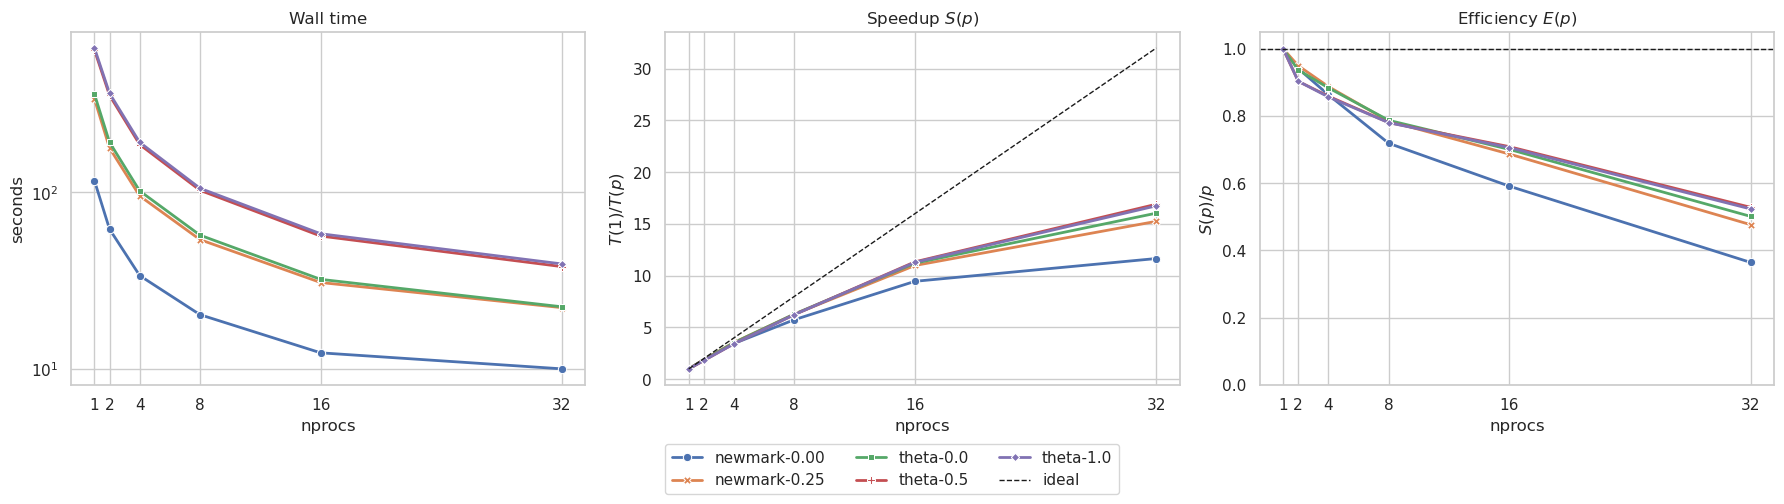

In [10]:
# --- Combined 3-panel plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Wall time
sns.lineplot(
    data=dfm_agg, x='nprocs', y='seconds',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[0], errorbar=None,
)
axes[0].set_title('Wall time')
axes[0].set_xlabel('nprocs')
axes[0].set_ylabel('seconds')
axes[0].set_yscale('log')
axes[0].set_xticks(sorted(dfm_agg['nprocs'].unique()))

# 2. Speedup
sns.lineplot(
    data=dfm_agg, x='nprocs', y='speedup',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[1], errorbar=None,
)
axes[1].plot([1, p_max], [1, p_max], color='k', linewidth=1, linestyle='--', label='ideal')
axes[1].set_title('Speedup $S(p)$')
axes[1].set_xlabel('nprocs')
axes[1].set_ylabel('$T(1)/T(p)$')
axes[1].set_xticks(sorted(dfm_agg['nprocs'].unique()))

# 3. Efficiency
sns.lineplot(
    data=dfm_agg, x='nprocs', y='efficiency',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[2], errorbar=None,
)
axes[2].axhline(1.0, color='k', linewidth=1, linestyle='--', label='ideal')
axes[2].set_title('Efficiency $E(p)$')
axes[2].set_xlabel('nprocs')
axes[2].set_ylabel('$S(p)/p$')
axes[2].set_xticks(sorted(dfm_agg['nprocs'].unique()))
axes[2].set_ylim(0, max(1.05, float(dfm_agg['efficiency'].max()) * 1.05))

handles, labels = axes[1].get_legend_handles_labels()
for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True, bbox_to_anchor=(0.5, -0.02))
fig.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

## 4. Conclusions

- The solver achieves **good strong scaling** up to 16 cores (for the chosen number of elements!) for all schemes.
- Implicit methods show similar scaling to each other.
- Explicit methods reaches lower efficiency due to the lower computational borden needed. This can be noticed given that the efficiency drop from 8 processor, for an explicit method we need an bigger system to make use of all that processors 
- The **Newmark $\beta=0$** (explicit central differences) scheme is the fastest in absolute terms, while **Newmark $\beta=0.25$** and **Crank–Nicolson ($\theta=0.5$)** offer unconditional stability at higher cost